![imagem](http://lapix.ufsc.br/wp-content/uploads/2022/09/NB-banner-PT.jpg)
# 15.2.2.Notebook para Segmentação por Instância - MASK2FORMER
#### Novembro de 2024

### Autores:
<b>Autores</b>:

*   Aldo von Wangenheim (aldo.vw@ufsc.br) [Review, Maintainer]
*   Rodrigo de Paula e Silva Ribeiro (ribeiro.rodrigo@posgrad.ufsc.br)  [Review, Code, Dataset, Maintainer]
*   Luis Otavio Santos (luis.otavio.santos@posgrad.ufsc.br) [Review, Code]


CERTIFIQUE-SE DE TER INCIADO O AMBIENTE EM MODO <b>GPU</b> ANTES DE REALIZAR OS PROCEDIMENTOS.<br>
NA TROCA DO AMBIENTE ELE <b><u>PERDE</u></b> TODOS OS DADOS BAIXADOS.

AO RE-EXECUTAR OS PROCEDIMENTOS (ex. diminuir o batch size), <br>REINICIE O AMBIENTE PARA LIBERAR O CACHE DO PYTORCH (reiniciar não perde os dados da sessão).<br>(alt+m ou pelo menu "Ambiente de Execução")

EXECUTE UTILIZANDO RUN ALL ou CTRL+F9


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/15.2.2.Mask2Former_Instance_Segmentation.ipynb)
![](https://github.com/awangenh/vision/blob/master/jupyter/License-CC-orange.svg?raw=true)
![](https://img.shields.io/badge/JupyterLab-4.2.6-blue)
![](https://img.shields.io/badge/Jupyter_Notebook-7.2.2-blue)
![](https://img.shields.io/badge/Python-3.11.10-greeng)

### Configurações de GPU e PATH

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [7] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0
Running on Google Colab =  False
CUDA GPUS NUMBER:  1


### Checar versão do cuda do sistema com cuda instalado no ambiente python

O Cuda no sistema deve ser igual ou superior a 12.2

In [2]:
!nvidia-smi

Tue Nov 26 03:21:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0            114W /  700W |   41543MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Suprimir Avisos Gerais na saida do notebook
Suprimir apenas "avisos", erros irá mostrar a causar e efetuará a parada do notebook normalmente.

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Instalação das Bibliotecas

In [4]:
import os
from IPython import get_ipython

INSTALL_LIBS = False # Setar para True para instalar localmente também (Não é necessário se estiver rodando nos conteiners Lapix)

if _ON_COLAB:
    INSTALL_LIBS = True

if INSTALL_LIBS:
    !pip install neptune
    # Verificar se já está instalando (para fazer run all quando precisar reiniciar a sessão) ou instalar o detectron2.
    try:
        import detectron2
        print("Detectron2 já está instalado")
        os.chdir(BASE_PATH)
    except ModuleNotFoundError:
            !pip install 'git+https://github.com/facebookresearch/detectron2.git'
            print("REINICIANDO SESSÃO!!\nRE-EXECUTE A PARTIR DA PRIMEIRA CELULA PARA CARREGAR O MODULO DETECTRON2 PARA O MASK2FORMER")
            if get_ipython():
                get_ipython().kernel.do_shutdown(restart=True)

### Verificar a instalação base e versão das bibliotecas

In [5]:
import torch
import torch, detectron2, cv2
torch.cuda.empty_cache()
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print(f'Device Name: {torch.cuda.get_device_name()}')
print(f'Device Available: {torch.cuda.is_available()}')
print(f'Device Count: {torch.cuda.device_count()}')
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

Device Name: NVIDIA H100 80GB HBM3
Device Available: True
Device Count: 1
torch:  2.5 ; cuda:  cu124
detectron2: 0.6


## Instalar o **Mask2Former**

Após a instalação o notebook será reiniciado, execute a partir daquida primeira célula novamente.<br>
As células possuem proteção contra execução dupla.

In [6]:
import os
from IPython import get_ipython
# função auxiliar para instalar o Mask2Former
def installMask2Former():
  os.chdir(BASE_PATH)
  !git clone https://github.com/facebookresearch/Mask2Former.git
  os.chdir(os.path.join(BASE_PATH, "Mask2Former"))
  !pip install git+https://github.com/cocodataset/panopticapi.git
  !pip install -r requirements.txt
  os.chdir(os.path.join(BASE_PATH,"Mask2Former/mask2former/modeling/pixel_decoder/ops"))
  !python setup.py build install
  os.chdir(BASE_PATH) # volta ao root content para confis de dataset
  print("REINICIANDO SESSÃO!!\nRE-EXECUTE A PARTIR DA PRIMEIRA CELULA PARA CARREGAR O MODULO MASK2FORMER")
  if get_ipython():
    get_ipython().kernel.do_shutdown(restart=True)


In [7]:
# Verificar se o Mask2Former já está instalado
import os
try:
  os.chdir(os.path.join(BASE_PATH, "Mask2Former")) # verificar se existe o dir e entrar nele para import
  import mask2former # testar o import
  print("Mask2Former já está instalado")
  print("Mask2Former Importado Corretamente")
  os.chdir(BASE_PATH)
except FileNotFoundError:
  installMask2Former()
except ModuleNotFoundError:
  installMask2Former()



Mask2Former já está instalado
Mask2Former Importado Corretamente


### Carregar configurações extrar para minimizar ocorências de NaN na Loss do **Mask2Former**

In [8]:
if os.path.isdir("/content/mta_changed") and _ON_COLAB:
    print("Configuração Mask2Former Colab Presente!\nPulando Etapa...")
elif _ON_COLAB:
    target = 'cost_dice = batch_dice_loss_jit(out_mask, tgt_mask)'
    replacer = """                if out_mask.shape[0] == 0 or tgt_mask.shape[0] == 0:
                    cost_mask = batch_sigmoid_ce_loss(out_mask, tgt_mask)
                    cost_mask[cost_mask.isnan()]=1e1
                    cost_dice = batch_dice_loss(out_mask, tgt_mask)
                    cost_dice[cost_dice.isnan()]=1e1
                    cost_class[cost_class.isnan()]=1e1
                else:
                    cost_mask = batch_sigmoid_ce_loss_jit(out_mask, tgt_mask)
                    cost_mask[cost_mask.isnan()]=1e1
                    cost_dice = batch_dice_loss_jit(out_mask, tgt_mask)
                    cost_dice[cost_dice.isnan()]=1e1
                    cost_class[cost_class.isnan()]=1e1"""


    matcher_path = "/content/Mask2Former/mask2former/modeling/matcher.py"
    idx_del = None
    to_del = 'cost_mask = batch_sigmoid_ce_loss_jit(out_mask, tgt_mask)'
    with open(matcher_path, 'r') as infile:
        new_matcher = infile.readlines()
        for i, line in enumerate(new_matcher):
            if to_del in line:
                idx_del = i
  
        new_matcher.pop(idx_del)

        for i, line in enumerate(new_matcher):
            if target in line:
                new_matcher[i] = replacer
    
    with open(matcher_path, 'w', encoding='utf-8') as outfile:
        outfile.writelines(new_matcher)
    os.makedirs("/content/mta_changed")
    print("Configuração Mask2Former Colab Carregada!")
else:
    !cp {BASE_PATH}/compartilhado/matcher.py {BASE_PATH}/Mask2Former/mask2former/modeling/matcher.py
    print("Configuração Mask2Former DGX/VLAB Carregada!")

Configuração Mask2Former DGX/VLAB Carregada!


# Segmentação por Instância x Segmentação Semântica (diferenças)
Ambas as segmentações classificam a imagem a nível de pixel.

A principal diferença entre elas é no modo como a imagem e as máscaras detectadas são tratadas.

Na segmentação semântica, cada pixel na tela terá uma classificação e as máscaras de objetos encontrados são unificadas (ex: 3 carros na imagem, porém uma única máscara para os 3 carros).

![imagem](https://drive.google.com/thumbnail?id=1xTcpqOMJaXc3QGUj2y7U5t-abSYihF7Y&sz=w400)




Na segmentação por instância, somente as máscaras de objetos reconhecidos serão classificadas e extraidas (qualquer objeto na tela que não esteja no conjunto de dados é automaticamente descartado), e cada objeto terá uma máscara individual, permitindo detectar várias instâncias de um mesmo objeto.

![imagem](https://drive.google.com/thumbnail?id=1qrm8HqWJHl-cDj7Jhqk37Ekk7aG_lLuo&sz=w400)

# Simple Street Instance Test Dataset
Este dataset é derivado do conjunto aberto "street": https://universe.roboflow.com/hmc-nbo1u/street-has4r <br>
Foi realizada uma limpeza, adequação de classes, verificação e adição de novas anotações.

Este dataset é para fins didáticos de funcionamento de segmentação por instância.

Classes:
* car
* bus
* truck
* traffic light
* motorcycle
* person

Amostra de anotações:<br>
![](https://drive.google.com/thumbnail?id=1B1z6p6FmU7KODn8hThMsGR-UrgohvfpN&sz=w400)
![](https://drive.google.com/thumbnail?id=1syPez_Dgg1SJkcU5yjoroUXNH6EfqAhN&sz=w400)
<br>
![](https://drive.google.com/thumbnail?id=17WMc9xcLXwIWaTqiUfNeiZw3N7PlwiGs&sz=w400)
![](https://drive.google.com/thumbnail?id=1YCtFawtuVDWMugm-UvVaKNV7g3TkMZb8&sz=w400)

<center>Diferenças das políticas de decaimento da Learning Rate.</center><br>
LR_METHODS.COSINE: Nesta política, após o aquecimento (subida) a Learning Rate irá decair suavemente com tendência a 0.<br>
LR_METHODS.STEP: Nesta política, após o aquecimento (subida) a Learning Rate irá decair por valores fixos e nos passos fixados previamente, tende a um valor específico resultado do decaimento do último passo.
<br><br>
<center>Exemplos de curvas das políticas de decaimento da Learning Rate.
<br>(laranja escuro= curva suavizada, laranja claro= curva natural)</center><br>

LR_METHODS.COSINE:<br>
![](https://drive.google.com/thumbnail?id=1ih5TR3qpT17WZtMl-RjIH7HK39eJ_0hb&sz=w800)

LR_METHODS.STEP:<br>
![](https://drive.google.com/thumbnail?id=1p87kdvgwqcmpym9lDy_LKhsj_04ydkDM&sz=w800)

## OneCycle
É um método de convergência acelerada proposto por Leslie N. Smith em 2017.
O método varia a taxa de aprendizado e momentum da rede de forma que a taxa de aprendizado sobe até um pico e depois decresce gradualmente, por outro lado,  o momentum da rede obedece uma curvatura inversa da taxa de aprendizagem como ilustrado abaixo.<br>
![imagem](https://miro.medium.com/max/720/1*38YBWIKFwXN0YlNOVo_LOA.jpeg)

O framework fast.ai implementa uma variação deste método e é um dos métodos mais utilizado no fast.ai. Também está disponível no framework pytorch (implementação original e do fast.ai). Este notebook utiliza-se da implementação do pytorch, deixando ao usuário a liberdade de escolha entre a variação do fast.ai ou o modo original.<br>Mais detalhes podem ser encontrados nos materiais a seguir:
* https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
* A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay — https://arxiv.org/abs/1803.09820
* Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates — https://arxiv.org/abs/1708.07120

In [9]:
from enum import Enum
#-- membros estáticos
LR_METHODS = Enum("LR_METHODS", "COSINE FIXED STEP ONECYCLE")
#--

"""
# CONFIGS GENERICAS
"""
# Define o número de épocas para rodar ex: 100
NUM_EPOCH = 25

# Define o intervalo de épocas para salvar, ex: de 1 em 1
SAVE_EPOCH = 5

# Define o batch_size, USAR BSIZE= 2 ou BSIZE=1 SE ESTIVER NO COLAB (Mask2Former consome muita VRAM)
BSIZE = 12

# Define a learnig rate base, ex: 0.01
LEARNING_RATE = 0.00005

# Número de iterações iniciais para aquecimento da LR. Somente usada se LR_METHODS != ONECYCLE
WARMUP_ITERS = 0

# Define o método para learning rate adaptativa.
# Atualmente disponíveis: LR_METHODS.COSINE, LR_METHODS.FIXED, LR_METHODS.STEP e LR_METHODS.ONECYCLE (ver gráficos/info no bloco acima)
# LR_METHODS.FIXED >> mantém a learning rate fixa o tempo todo sem decaimento.
LR_METHOD = LR_METHODS.ONECYCLE

"""
# COSINE CONFIGS (LR_METHODS.COSINE)
"""
# Define o momentum base para a LR no método Cosine.
LR_MOMENTUM = 0.9


"""
# STEP CONFIGS (LR_METHODS.STEP)
"""
# Array das n% de decay em 0-1, ex: 60%, 80%, 90% = [0.6, 0.8, 0.9], primeiro decay aos 60% do conjunto treinado, segundo aos 80% e terceiro/último aos 90%.
LR_STEPS_DECAY = [0.6, 0.8]

# Define o quanto vai decair a Learning Rate atual em cada passo: LR_BASE = 0.1, decay1 = LR_BASE * STEP_RATE = 0.01, decay2 = NOVA_LR(0.01) * STEP_RATE = 0.001, etc..
LR_STEP_RATE = 0.1

"""
# ONECYCLE CONFIGS (LR_METHODS.ONECYCLE)
"""
# limite maximo de crescimento da learning rate
# **ATENÇÃO**: Mask2Former possui uma loss maior que o normal, considere um limite superior bom para evitar divergência.
OC_LIMIT = 0.0001

# momentum minimo
OC_MIN_MOMENTUM = 0.85

# momentum maximo
OC_MAX_MOMENTUM = 0.95

# True para usar a versao original do Artigo. False para usar a modificação do pytorch/fast.ai (não publicado mas teoricamente melhor)
OC_THREE_PHASE = False


"""
# CONFIGS PARA RESUMO DE TREINO
"""
# False = novo treino, ao RESUMIR AS CONFIG ACIMA SAO IGNORADAS E CARREGADAS DO ARQUIVO DO MODELO (para evitar erros por diferença)
RESUMIR = False 

 # pasta onde foi salvo o treino a ser resumido
PASTA_RESUMO = "27-8-2022_12_32_40"

"""
# CONFIGS DE PASTA PARA SALVAMENTO 
"""
PROJECT_NAME = "Mask2Former_Instance"

# Setar True e montar o drive na proxima célula se quiser salvar as runs no drive (Exclusivo para uso no Colab)
GDRIVE_SAVE = False 

## Descrição dos Loggers e suas funções.
Este notebook oferece logging de informações do treino para ambiente externo.
Mais especificamente para: [WandB](https://wandb.ai/) e [Neptune](https://neptune.ai/).<br>
WandB e Neptune são gerenciadores de projetos de machine learning que possibilitam a comparação analítica de maneira facilitada entre vários treinos de um mesmo modelo comparando diferentes parâmetros.<br>
Há ainda opções avançadas para salvar modelos e datasets na nuvem (necessita assinatura paga) de forma a facilitar a portabilidade entre diferentes frameworks de ML.<br>
Para utilizá-los, é necessário acessar o site (clikar nos links acima) e efetuar um cadastro gratuito para obter uma chave de api.<br>
Após, alterar no bloco abaixo, os locais indicados com as chaves e mudar a variável de ativação para "True".<br>
Caso não deseje utilizar loggers externos, manter as variáveis de ativação em "False".<br>
O [Detectron2](https://github.com/facebookresearch/detectron2), por padrão, ao final do treino, irá gerar um arquivo 'metrics.json', onde é possível visualizar e analisar os dados de treino e eventualmente montar seu próprio comparador analítico entre treinos.

In [10]:
"""
# EXTERNAL LOGGERS
"""
WANDB_LOGGER = False # Ativa o log das métricas básicas no wandb.ai, requer mais configurações abaixo.
NPT_LOGGER = False # Ativa o log das métricas básicas no nepture.ai, requer mais configurações abaixo.

"""
# WANDB CONFIG
"""
WANDB_API_KEY = "***" # wandb.ai api-key, trocar *** por sua api key
WANDB_PROJECT_NAME = "Cones-Teste" # Nome do projeto onde será logado as métricas (pode ser projeto já existente), caso deixe vazio será gerado um nome aleatório no wandb.ai
WANDB_ENTITY = "wndb_username" # A entidade que está enviando os dados.
WANDB_RUN_ID = "" # Em caso de resumo é necessário passar o RUN-ID para continuar logando as métricas na mesma run.

"""
# NEPTUNE CONFIG
"""
NPT_PROJECT_NAME = "---" # O nome do projeto para o qual será enviado os dados (definido no neptune.ai).
NPT_TOKEN = "***" # A api token do neptune.ai, trocar *** pela sua api key fornecida no neptune.ai
NPT_RUN_ID = "" # Em caso de resumo é necessário passar o RUN-ID para continuar logando na mesma run.

# 1 Montar o google drive
Apenas para usuarios do colab

In [11]:
# Caso queira salvar treinamento no google drive, rodar estar célular.
if GDRIVE_SAVE:
    from google.colab import drive
    DRIVE_PATH = os.path.join(BASE_PATH, "gdrive")
    drive.mount(DRIVE_PATH, force_remount=False)

# 2 Realizar o download dos arquivos necessários.
Download e extração do dataset e demais arquivos necessários.


In [12]:
import os
from glob import glob

if GDRIVE_SAVE:
  RUNS_PATH = os.path.join(DRIVE_PATH,PROJECT_NAME)
else:
  RUNS_PATH = os.path.join(BASE_PATH,PROJECT_NAME)
os.makedirs(RUNS_PATH, exist_ok=True)
os.chdir(BASE_PATH)
if os.path.isdir(os.path.join(BASE_PATH, "dataset")):
    print("Dataset já existe no caminho, pulando etapa!")
else:
    # download street dataset
    !gdown 1wBtdJjlBqOD5Oqo-QUXP-Z4vn32LnuVH
    os.makedirs(os.path.join(BASE_PATH, "dataset"), exist_ok=True)
    !mv simple_street_segmentation.zip {BASE_PATH}/dataset/
    os.chdir(os.path.join(BASE_PATH, "dataset"))
    !unzip -qq -u simple_street_segmentation.zip
    !rm -rf simple_street_segmentation.zip
    os.chdir(BASE_PATH)
    print("Download e Extração do dataset FINALIZADA!")

Dataset já existe no caminho, pulando etapa!


# 3 Conversão de dados para o formato COCO.
Realiza a conversão do formato labelme para [coco](https://cocodataset.org/#home) json.<br>
Caso não precise conversão (como é o caso deste dataset, pule esta etapa), caso precise de outra conversão, realizar neste bloco.



In [13]:
import os
if RESUMIR:
  print("Conversão do dataset para formato COCO: Pulando etapa... (modo de resumo já possui essa conversão).")
else:
  #!python label2coco.py "{BASE_PATH}/dataset/" --output "coco_format.json" # este dataset já está vindo no formato COCO, linha mantida apenas para referência
  print("Dataset já está no formato coco")

Dataset já está no formato coco


# 4 Divisão do dataset em train, val e test.
É usual em tarefas de Machine Learning e Deep Learning, utilizar-se de 2 a 3 subconjuntos extraidos do dataset principal.<br>
Normalmente são nomeados como Train, Val e Test Split. Ou seja, divisão de treino, validação e teste.<br>
A rede é treinada com a divisão "train", de forma que as divisões val e test são desconhecidas para a rede.<br>
Desta forma é possível verificar situações como "Overfitting", caso que ocorre quando a rede vai bem no conjunto de treino e vai mal nos conjuntos de val e test (decora os dados mas não aprende de fato).<br>
A proporção mais utilizada é a de: 70%, 15%, 15% no caso de train/val/test ou 70%/30% (train/val).<br>
Este notebook utiliza-se de 3 conjuntos na proporção 70/15/15.<br>
Ao final do treino é realizada uma inferência no conjunto 'val' automaticamente.<br>

In [14]:
import json
from sklearn.model_selection import train_test_split
def save_coco(file, images, annotations, categories):
    with open(file, 'w') as coco:
        json.dump({ 'images': images, 'annotations': annotations, 'categories': categories}, coco, indent=2, sort_keys=True)

def filter_annotations(annotations, images):
    image_ids = map(lambda i: int(i['id']), images)
    image_ids = list(image_ids)
    filtered = filter(lambda a: int(a['image_id']) in image_ids, annotations)
    return list(filtered)

if RESUMIR:
  print("Divisão train/val/test do dataset: Pulando etapa... (modo de resumo já possui estas definições)")
else:
  print("Dataset já possui divisão train/val/test") # o dataset já está dividido em train,val e test, código mantido para referência.
  """
  _train = 0.7
  _val = 0.15
  _test = 0.15

  with open('/content/dataset/coco_format.json', 'r') as infile:
    coco = json.load(infile)
    images = coco['images']
    annotations = coco['annotations']
    categories = coco['categories']
    train_set, y = train_test_split(images, train_size=_train)
    val_set, test_set = train_test_split(y, train_size= (_val/(_val + _test)))
    os.chdir("/content/")
    save_coco('train.json', train_set, filter_annotations(annotations, train_set), categories)
    save_coco('val.json', val_set, filter_annotations(annotations, val_set), categories)
    save_coco('test.json', test_set, filter_annotations(annotations, test_set), categories)
  """

Dataset já possui divisão train/val/test


#### Custom Mapper

Exemplo para criar um mapeamento de arquivos utilizando por exemplo um dicionário<br>
Apenas informativo caso queria criar um dataloader para um dataset personalizado que não seja COCO Format

In [15]:
def CustomMapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = read_image(dataset_dict["file_name"], format="BGR")
    # Implementa data augmentation conforme necessário, ver detectron.data.transforms para mais detalhes e opções
    auginput = T.AugInput(image)
    transform = T.Resize((800, 800))(auginput)
    # END Augmentations
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1))
    annos = [transform_instance_annotations(annotation, [transform], image.shape[1:]) for annotation in dataset_dict.pop("annotations") ]
    return {"image": image, "instances": annotations_to_instances(annos, image.shape[1:])}


# 5 Customizações Lapix/DeepUFSC para as classes Detectron2
Modificações necessárias nas classes CORE para implementar o Mask2Former<br>
Customizações para LRScheduler, Hook de Validação e Loggers Externos

In [16]:
import torch
from torch import autocast
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.evaluation import COCOEvaluator,CityscapesInstanceEvaluator, CityscapesSemSegEvaluator, COCOEvaluator, COCOPanopticEvaluator, DatasetEvaluators, LVISEvaluator, SemSegEvaluator, verify_results
from detectron2.utils.events import get_event_storage
import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.solver.build import build_lr_scheduler, build_optimizer, get_default_optimizer_params, maybe_add_gradient_clipping
from detectron2.solver.lr_scheduler import WarmupCosineLR, WarmupMultiStepLR, LRMultiplier, WarmupParamScheduler
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data import transforms as T
from detectron2.data.detection_utils import annotations_to_instances, transform_instance_annotations, read_image
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from fvcore.common.param_scheduler import CosineParamScheduler, MultiStepParamScheduler, StepWithFixedGammaParamScheduler
from detectron2.engine import HookBase, default_argument_parser, default_setup, launch, DefaultTrainer, AMPTrainer
from fvcore.common.param_scheduler import CosineParamScheduler, MultiStepParamScheduler, StepWithFixedGammaParamScheduler
from collections import defaultdict, OrderedDict
import copy
import itertools
from typing import Any, Dict, List, Set
import logging
import matplotlib.pyplot as plt
import datetime
import pytz
import numpy as np
import json
import neptune as neptune
import wandb
import os

import sys
sys.path.append('/lapix/Mask2former')
from mask2former import COCOInstanceNewBaselineDatasetMapper, COCOPanopticNewBaselineDatasetMapper, InstanceSegEvaluator, MaskFormerInstanceDatasetMapper, MaskFormerPanopticDatasetMapper, MaskFormerSemanticDatasetMapper, SemanticSegmentorWithTTA, add_maskformer2_config

class ValidationLoss(HookBase):
    """
    Hook para calcular loss durante o treinamento com o set val a cada 20 iterações
    """
    def __init__(self, cfg, period=20):
        super().__init__()
        self.cfg = cfg.clone()
        self._period = period
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.TEST
        # Semantic segmentation dataset mapper
        if cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_semantic":
            mapper = MaskFormerSemanticDatasetMapper(cfg, is_train=True)
            #return build_detection_train_loader(cfg, mapper=mapper)
        # Panoptic segmentation dataset mapper
        elif cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_panoptic":
            mapper = MaskFormerPanopticDatasetMapper(cfg, is_train=True)
        # Instance segmentation dataset mapper
        elif cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_instance":
            mapper = MaskFormerInstanceDatasetMapper(cfg, is_train=True)
        # coco instance segmentation lsj new baseline
        elif cfg.INPUT.DATASET_MAPPER_NAME == "coco_instance_lsj":
            mapper = COCOInstanceNewBaselineDatasetMapper(cfg, is_train=True)
        # coco panoptic segmentation lsj new baseline
        elif cfg.INPUT.DATASET_MAPPER_NAME == "coco_panoptic_lsj":
            mapper = COCOPanopticNewBaselineDatasetMapper(cfg, is_train=True)
        # custom data mapper se necessario
        else:
            mapper = CustomMapper(DatasetCatalog.get(cfg.DATASETS.TEST[0]))
        #self._loader = iter(build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST, mapper=mapper))
        self._loader = iter(build_detection_train_loader(self.cfg, mapper=mapper))
        
        

    def after_step(self):
        data = next(self._loader)
        if (self.trainer.iter + 1) % self._period == 0 or (self.trainer.iter == self.trainer.max_iter - 1):
            with torch.no_grad():
                loss_dict = self.trainer.model(data)
                losses = sum(loss_dict.values())
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                assert torch.isfinite(losses).all(), loss_dict
                loss_dict_reduced = {"validation_" + k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
                losses_reduced = sum(loss for loss in loss_dict_reduced.values())
                if comm.is_main_process():
                    self.trainer.storage.put_scalars(validation_total_loss=losses_reduced, **loss_dict_reduced)
                    comm.synchronize()

class ExternalLogger(HookBase):
    """
    Hook para enviar os dados de treino para o WandB.ai e/ou Neptune.ai
    """
    def __init__(self, period=20, npt=False, wndb=False, resume=False, maxiter = 0):
        super().__init__()
        self._period = period
        self._npt = npt
        self._wndb = wndb
        self._resume = resume
        self._last = -1
        self._params = {"batch_size": BSIZE, "epochs": NUM_EPOCH, "learning_rate": LEARNING_RATE, "scheduler": LR_METHOD.name, "iterations": maxiter}
        if self._npt:
            if self._resume:
                self._npt_run = neptune.init_run(project=NPT_PROJECT_NAME, api_token=NPT_TOKEN, with_id=NPT_RUN_ID)
            else:
                self._npt_run = neptune.init_run(project=NPT_PROJECT_NAME, api_token=NPT_TOKEN)
        if self._wndb:
            os.environ["WANDB_SILENT"] = "True"
            os.environ["WANDB_API_KEY"] = WANDB_API_KEY
            if self._resume:
                self._wnd_run = wandb.init(project=WANDB_PROJECT_NAME, entity=WANDB_ENTITY, id=WANDB_RUN_ID, resume="must")
            else:
                self._wnd_run = wandb.init(project=WANDB_PROJECT_NAME, entity=WANDB_ENTITY)
        if not self._resume:
            self._npt_run["parameters"] = self._params
            wandb.config.update(self._params)

    def after_step(self):
        if (self.trainer.iter + 1) % self._period == 0 or (self.trainer.iter == self.trainer.max_iter - 1):
            storage = get_event_storage()
            _iter = storage.iter
            self._last = _iter
            for k, (v, iter) in storage.latest_with_smoothing_hint(self._period).items():
                if self._wndb:
                    if self._resume:
                        if wandb.run.step < _iter:
                            wandb.log({f'{k.replace("/", "-")}': v}, step=_iter)
                    else:
                        wandb.log({f'{k.replace("/", "-")}': v}, step=_iter)
                if self._npt:
                    if self._resume:
                        if self._npt_run["last_iter"].fetch() < _iter:
                            self._npt_run[k.replace("/", "-")].log(v, step=_iter)
                    else:
                        self._npt_run[k.replace("/", "-")].log(v, step=_iter)
                        self._npt_run["last_iter"] = _iter

    def after_train(self):
        storage = get_event_storage()
        for k, (v, iter) in storage.latest_with_smoothing_hint(self._period).items():
            if iter <= self._last:
                continue
            if self._wndb:
                wandb.log({f'{k.replace("/", "-")}': v}, step=iter)
            if self._npt:
                self._npt_run[k.replace("/", "-")].log(v, step=iter)
        if self._wndb:
            self._wnd_run.finish()
        if self._npt:
            self._npt_run.stop()

class DeepUFSCTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "evaluations")
            os.makedirs(output_folder, exist_ok=True)
        evaluator_list = []
        evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
        # semantic segmentation
        if evaluator_type in ["sem_seg", "ade20k_panoptic_seg"]:
            evaluator_list.append(
                SemSegEvaluator(
                    dataset_name,
                    distributed=True,
                    output_dir=output_folder,
                )
            )
        # instance segmentation
        if evaluator_type == "coco":
            evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
        # panoptic segmentation
        if evaluator_type in [
            "coco_panoptic_seg",
            "ade20k_panoptic_seg",
            "cityscapes_panoptic_seg",
            "mapillary_vistas_panoptic_seg",
        ]:
            if cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON:
                evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
        # COCO
        if evaluator_type == "coco_panoptic_seg" and cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON:
            evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
        if evaluator_type == "coco_panoptic_seg" and cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON:
            evaluator_list.append(SemSegEvaluator(dataset_name, distributed=True, output_dir=output_folder))
        # Mapillary Vistas
        if evaluator_type == "mapillary_vistas_panoptic_seg" and cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON:
            evaluator_list.append(InstanceSegEvaluator(dataset_name, output_dir=output_folder))
        if evaluator_type == "mapillary_vistas_panoptic_seg" and cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON:
            evaluator_list.append(SemSegEvaluator(dataset_name, distributed=True, output_dir=output_folder))
        # Cityscapes
        if evaluator_type == "cityscapes_instance":
            assert (
                torch.cuda.device_count() > comm.get_rank()
            ), "CityscapesEvaluator currently do not work with multiple machines."
            return CityscapesInstanceEvaluator(dataset_name)
        if evaluator_type == "cityscapes_sem_seg":
            assert (
                torch.cuda.device_count() > comm.get_rank()
            ), "CityscapesEvaluator currently do not work with multiple machines."
            return CityscapesSemSegEvaluator(dataset_name)
        if evaluator_type == "cityscapes_panoptic_seg":
            if cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON:
                assert (
                    torch.cuda.device_count() > comm.get_rank()
                ), "CityscapesEvaluator currently do not work with multiple machines."
                evaluator_list.append(CityscapesSemSegEvaluator(dataset_name))
            if cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON:
                assert (
                    torch.cuda.device_count() > comm.get_rank()
                ), "CityscapesEvaluator currently do not work with multiple machines."
                evaluator_list.append(CityscapesInstanceEvaluator(dataset_name))
        # ADE20K
        if evaluator_type == "ade20k_panoptic_seg" and cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON:
            evaluator_list.append(InstanceSegEvaluator(dataset_name, output_dir=output_folder))
        # LVIS
        if evaluator_type == "lvis":
            return LVISEvaluator(dataset_name, output_dir=output_folder)
        if len(evaluator_list) == 0:
            raise NotImplementedError(
                "no Evaluator for the dataset {} with the type {}".format(
                    dataset_name, evaluator_type
                )
            )
        elif len(evaluator_list) == 1:
            return evaluator_list[0]
        return DatasetEvaluators(evaluator_list)

    @classmethod
    def build_train_loader(cls, cfg):
        # Semantic segmentation dataset mapper
        if cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_semantic":
            mapper = MaskFormerSemanticDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # Panoptic segmentation dataset mapper
        elif cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_panoptic":
            mapper = MaskFormerPanopticDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # Instance segmentation dataset mapper
        elif cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_instance":
            mapper = MaskFormerInstanceDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # coco instance segmentation lsj new baseline
        elif cfg.INPUT.DATASET_MAPPER_NAME == "coco_instance_lsj":
            mapper = COCOInstanceNewBaselineDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # coco panoptic segmentation lsj new baseline
        elif cfg.INPUT.DATASET_MAPPER_NAME == "coco_panoptic_lsj":
            mapper = COCOPanopticNewBaselineDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # custom data mapper se necessario
        else:
            mapper = CustomMapper(DatasetCatalog.get(cfg.DATASETS.TRAIN[0]))
            return build_detection_train_loader(cfg, mapper=mapper)

    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        name = cfg.SOLVER.LR_SCHEDULER_NAME
        if name == "WarmupMultiStepLR":
            steps = [x for x in cfg.SOLVER.STEPS if x <= cfg.SOLVER.MAX_ITER]
            if len(steps) != len(cfg.SOLVER.STEPS):
                logger = logging.getLogger(__name__)
                logger.warning("SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.")
            sched = MultiStepParamScheduler(
              values=[cfg.SOLVER.GAMMA**k for k in range(len(steps) + 1)],
              milestones=steps,
              num_updates=cfg.SOLVER.MAX_ITER,
            )
        elif name == "WarmupCosineLR":
            end_value = cfg.SOLVER.BASE_LR_END / cfg.SOLVER.BASE_LR
            assert end_value >= 0.0 and end_value <= 1.0, end_value
            sched = CosineParamScheduler(1, end_value)
        elif name == "WarmupStepWithFixedGammaLR":
            sched = StepWithFixedGammaParamScheduler(
              base_value=1.0,
              gamma=cfg.SOLVER.GAMMA,
              num_decays=cfg.SOLVER.NUM_DECAYS,
              num_updates=cfg.SOLVER.MAX_ITER,
            )
        elif name == "OneCycleLR":
            return torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=cfg.ONECYCLE.LIMIT, base_momentum=cfg.ONECYCLE.MIN_MOMENTUM, max_momentum=cfg.ONECYCLE.MAX_MOMENTUM, total_steps=cfg.SOLVER.MAX_ITER, three_phase=cfg.ONECYCLE.THREE_PHASE)
        else:
            print("Unknown LR scheduler: {}".format(name), "Switching to Default")
            return build_lr_scheduler(cfg, optimizer)

        sched = WarmupParamScheduler(
          sched,
          cfg.SOLVER.WARMUP_FACTOR,
          min(cfg.SOLVER.WARMUP_ITERS / cfg.SOLVER.MAX_ITER, 1.0),
          cfg.SOLVER.WARMUP_METHOD,
          cfg.SOLVER.RESCALE_INTERVAL,
        )
        return LRMultiplier(optimizer, multiplier=sched, max_iter=cfg.SOLVER.MAX_ITER)

    @classmethod
    def build_optimizer(cls, cfg, model):
        weight_decay_norm = cfg.SOLVER.WEIGHT_DECAY_NORM
        weight_decay_embed = cfg.SOLVER.WEIGHT_DECAY_EMBED

        defaults = {}
        defaults["lr"] = cfg.SOLVER.BASE_LR
        defaults["weight_decay"] = cfg.SOLVER.WEIGHT_DECAY

        norm_module_types = (
            torch.nn.BatchNorm1d,
            torch.nn.BatchNorm2d,
            torch.nn.BatchNorm3d,
            torch.nn.SyncBatchNorm,
            # NaiveSyncBatchNorm inherits from BatchNorm2d
            torch.nn.GroupNorm,
            torch.nn.InstanceNorm1d,
            torch.nn.InstanceNorm2d,
            torch.nn.InstanceNorm3d,
            torch.nn.LayerNorm,
            torch.nn.LocalResponseNorm,
        )

        params: List[Dict[str, Any]] = []
        memo: Set[torch.nn.parameter.Parameter] = set()
        for module_name, module in model.named_modules():
            for module_param_name, value in module.named_parameters(recurse=False):
                if not value.requires_grad:
                    continue
                # Avoid duplicating parameters
                if value in memo:
                    continue
                memo.add(value)

                hyperparams = copy.copy(defaults)
                if "backbone" in module_name:
                    hyperparams["lr"] = hyperparams["lr"] * cfg.SOLVER.BACKBONE_MULTIPLIER
                if (
                    "relative_position_bias_table" in module_param_name
                    or "absolute_pos_embed" in module_param_name
                ):
                    print(module_param_name)
                    hyperparams["weight_decay"] = 0.0
                if isinstance(module, norm_module_types):
                    hyperparams["weight_decay"] = weight_decay_norm
                if isinstance(module, torch.nn.Embedding):
                    hyperparams["weight_decay"] = weight_decay_embed
                params.append({"params": [value], **hyperparams})

        def maybe_add_full_model_gradient_clipping(optim):
            # detectron2 doesn't have full model gradient clipping now
            clip_norm_val = cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE
            enable = (
                cfg.SOLVER.CLIP_GRADIENTS.ENABLED
                and cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model"
                and clip_norm_val > 0.0
            )

            class FullModelGradientClippingOptimizer(optim):
                def step(self, closure=None):
                    all_params = itertools.chain(*[x["params"] for x in self.param_groups])
                    torch.nn.utils.clip_grad_norm_(all_params, clip_norm_val)
                    super().step(closure=closure)

            return FullModelGradientClippingOptimizer if enable else optim

        optimizer_type = cfg.SOLVER.OPTIMIZER
        if optimizer_type == "SGD":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.SGD)(
                params, cfg.SOLVER.BASE_LR, momentum=cfg.SOLVER.MOMENTUM
            )
        elif optimizer_type == "ADAMW":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.AdamW)(
                params, cfg.SOLVER.BASE_LR
            )
        else:
            raise NotImplementedError(f"no optimizer type {optimizer_type}")
        if not cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model":
            optimizer = maybe_add_gradient_clipping(cfg, optimizer)
        return optimizer

    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA.
        logger.info("Running inference with test-time augmentation ...")
        model = SemanticSegmentorWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.VAL
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res

# 6 Instanciar a classe e realizar o treinamento
Pode-se alterar o modelo de backbone do Mask2Former (ver github).
Para incluir seu dataset customizado, abaixo segue as linhas que necessitam alterações.

Para mais modelos consulte: <a href=https://github.com/facebookresearch/Mask2Former/blob/main/MODEL_ZOO.md>Mask2Former Model Zoo</a>

Caso deseje trocar o modelo em uso altere as seguintes linhas:<br>
<code>cfg.merge_from_file("Mask2Former/configs/coco/instance-segmentation/maskformer2_R50_bs16_50ep.yaml")<br>
cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/panoptic/maskformer2_R50_bs16_50ep/model_final_94dc52.pkl"</code><br>

Para rodar em um dataset customizado, é necessário alterar o número de classes da última camada, alterando a seguinte linha:<br>
<code>cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 # numero de classes do dataset</code><br>

Para modelos utilizados puramente para segmentação semântica, adicionar a seguinte linha:<br>
<code>cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 6 # numero de classes para segmentação semantica</code><br>

<b>Para outros modelos consulte a documentação do Detectron2 para quais atributos adicionais são necessários.</b>

O Detectron2 espera dataset no formato coco com um arquivo json para cada split (train, test, val), as imagens podem estar na mesma pasta.<br>
Para adicionar um dataset customizado, procure e edite as seguintes linhas:<br>
<code>
register_coco_instances("instance_train", {}, "/content/dataset/simple_street_segmentation/train/train.json", "/content/dataset/simple_street_segmentation/train")<br>
register_coco_instances("instance_val", {}, "/content/dataset/simple_street_segmentation/valid/valid.json", "/content/dataset/simple_street_segmentation/valid")<br>
</code>

O formato para registrar um dataset com a função register_coco_instances segue abaixo:<br>
<code>register_coco_instances("nome_para_localizar", {}, "caminho para o arquivo json", "caminho para as imagens")</code><br>

Para adicioanr ao CFG, procure e altere as seguintes linhas:<br>
<code>cfg.DATASETS.TRAIN = ("instance_train",)<br>
cfg.DATASETS.TEST = ("instance_val",)</code><br>

Altere para:<br>
<code>cfg.DATASETS.TRAIN = ("nome_registrado_para_split_train",)<br>
cfg.DATASETS.TEST = ("nome_registrado_para_split_validation",)</code><br>

Outras opções estão comentadas no código.

In [17]:
import detectron2
from detectron2.utils.logger import setup_logger
import matplotlib.pyplot as plt
import datetime
import pytz
import numpy as np
import cv2
import os
from detectron2.config import get_cfg
from detectron2.config import CfgNode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo
from detectron2.engine import PeriodicWriter

import logging

if RESUMIR:
    print("Modo de resumo selecionado: Pulando etapa de treinamento novo")
else:
    time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
    _msg = "Iniciando treino: OK (treino iniciado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
    print(_msg)
    #setup_logger()

    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_maskformer2_config(cfg)
    cfg.ONECYCLE = CfgNode({"LIMIT": OC_LIMIT, "MAX_MOMENTUM": OC_MAX_MOMENTUM, "MIN_MOMENTUM": OC_MIN_MOMENTUM, "THREE_PHASE": OC_THREE_PHASE})
    cfg.merge_from_file("Mask2Former/configs/coco/instance-segmentation/maskformer2_R50_bs16_50ep.yaml")
    cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/instance/maskformer2_swin_base_IN21k_384_bs16_50ep/model_final_83d103.pkl"
    cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = False
    cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True 
    cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = False
    #cfg.INPUT.DATASET_MAPPER_NAME = "mask_former_semantic"
    #cfg.INPUT.DATASET_MAPPER_NAME = "mask_former_instance"
    cfg.INPUT.DATASET_MAPPER_NAME = "coco_instance_lsj" # DatasetMapper Coco para tarefas de Segmentação (semantica/instancia) e Detecção de Objetos por BoundingBox
    #cfg.INPUT.DATASET_MAPPER_NAME = "custom"
    
    
    ##-- Definir os caminhos dos datasets
    DatasetCatalog.clear()
    MetadataCatalog.clear()
    register_coco_instances("instance_train", {}, os.path.join(BASE_PATH, "dataset/simple_street_segmentation/train/train.json"), os.path.join(BASE_PATH, "dataset/simple_street_segmentation/train"))
    register_coco_instances("instance_val", {}, os.path.join(BASE_PATH, "dataset/simple_street_segmentation/valid/valid.json"), os.path.join(BASE_PATH, "dataset/simple_street_segmentation/valid"))
    cfg.DATASETS.TRAIN = ("instance_train",)
    cfg.DATASETS.TEST = ("instance_val",)
    ##-- END definir caminhos datasets

    ##---------CONFIGURACOES COMEÇAM DAQUI PARA BAIXO ------------------------##
    cfg.DATALOADER.NUM_WORKERS = 1 # numero de subprocessos para usar no dataloader para pré-carregar as imagens (via cpu). Depende da quantidade de cores do cpu e da memoria disponível no sistema. [2-4]
    cfg.SOLVER.BASE_LR = LEARNING_RATE
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 # qtos rois da RPN vão ser usados para verificar region/classification loss durante o treino, ideal multiplo de 2.
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 # numero de classes do nosso dataset
    cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 6
    cfg.SOLVER.IMS_PER_BATCH = BSIZE # 
    cfg.MODEL.RPN.NMS_THRESH = 0.7
    cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.7]
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
    
    # Calculando iteracao em épocas
    NR_IMG = len(DatasetCatalog.get('instance_train'))
    EPOCH = NR_IMG / cfg.SOLVER.IMS_PER_BATCH
    cfg.SOLVER.MAX_ITER = int(NUM_EPOCH * EPOCH)
    cfg.SOLVER.WARMUP_ITERS = WARMUP_ITERS
    if LR_METHOD == LR_METHODS.COSINE:
        cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
        cfg.SOLVER.MOMENTUM = LR_MOMENTUM
    elif LR_METHOD == LR_METHODS.STEP:
        cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
        cfg.SOLVER.GAMMA = LR_STEP_RATE
        cfg.SOLVER.STEPS = tuple( [int(cfg.SOLVER.MAX_ITER*LR_STEPS_DECAY[i]) for i in range(len(LR_STEPS_DECAY))])
    elif LR_METHOD == LR_METHODS.FIXED:
        cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
        cfg.SOLVER.STEPS = []
    elif LR_METHOD == LR_METHODS.ONECYCLE:
        cfg.SOLVER.LR_SCHEDULER_NAME = "OneCycleLR"
        cfg.ONECYCLE.LIMIT = OC_LIMIT
        cfg.ONECYCLE.MIN_MOMENTUM = OC_MIN_MOMENTUM
        cfg.ONECYCLE.MAX_MOMENTUM = OC_MAX_MOMENTUM
        cfg.ONECYCLE.THREE_PHASE = OC_THREE_PHASE
        cfg.SOLVER.WARMUP_ITERS = 0
        cfg.SOLVER.STEPS = []
    else:
        pass

    EPOCH_RATIO = NUM_EPOCH / SAVE_EPOCH
    
    # checkpoint period faz o dt salvar o modelo atual a cada x iterações definidas aqui
    cfg.SOLVER.CHECKPOINT_PERIOD = int(cfg.SOLVER.MAX_ITER/EPOCH_RATIO)
    current_run = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
    dirname = "{dia}-{mes}-{ano}_{hora}_{minuto}_{segundo}".format(dia=current_run.day, mes=current_run.month, ano=current_run.year, hora=current_run.hour, minuto=current_run.minute, segundo=current_run.second)
    OUTDIR = os.path.join(RUNS_PATH, dirname)
    os.makedirs(OUTDIR, exist_ok=True)
    cfg.OUTPUT_DIR = OUTDIR
    
    default_setup(cfg, '')
    setup_logger(output=cfg.OUTPUT_DIR, distributed_rank=comm.get_rank(), name="mask2former")

    with open(os.path.join(OUTDIR, 'mask2former_instance.yml'),'w') as f:
        f.write(cfg.dump())

    trainer = DeepUFSCTrainer(cfg)
    trainer.register_hooks([ValidationLoss(cfg)])
    pw_hook = [hook for hook in trainer._hooks if isinstance(hook, PeriodicWriter)]
    all_hooks = [hook for hook in trainer._hooks if not isinstance(hook, PeriodicWriter)]
    trainer._hooks = all_hooks + pw_hook
    if WANDB_LOGGER or NPT_LOGGER:
        exlogger_hook = ExternalLogger(npt=NPT_LOGGER, wndb=WANDB_LOGGER, resume=False, maxiter=cfg.SOLVER.MAX_ITER)
        trainer.register_hooks([exlogger_hook])
  
    trainer.resume_or_load(resume=False)
    trainer.train()

    #--msg logger--#
    time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
    _msg = "Treino terminado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
    print(_msg)

Iniciando treino: OK (treino iniciado em 26/11/2024 as 0:24:26)
[11/26 03:24:26 detectron2]: Rank of current process: 0. World size: 1
[11/26 03:24:27 detectron2]: Environment info:
-------------------------------  -----------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.11.10 (main, Oct  3 2024, 07:29:13) [GCC 11.2.0]
numpy                            1.26.4
detectron2                       0.6 @/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/detectron2
Compiler                         GCC 11.4
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.5.1+cu124 @/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    Yes
GPU 0                            NVIDIA H100 80GB HBM3 (arch=9.0)
Driver v

# 7 Realizar inferência com o conjunto Test

In [18]:
from detectron2.config import CfgNode
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import torch
cfg_test = get_cfg()
add_deeplab_config(cfg_test)
add_maskformer2_config(cfg_test)
cfg_test.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})
cfg_test.merge_from_file(os.path.join(OUTDIR, "mask2former_instance.yml"))
cfg_test.MODEL.WEIGHTS = os.path.join(OUTDIR, "model_final.pth")
cfg_test.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
with torch.no_grad():
  predictor = DefaultPredictor(cfg_test)
  model = predictor.model
  register_coco_instances("instance_test", {}, os.path.join(BASE_PATH, "dataset/simple_street_segmentation/test/test.json"), os.path.join(BASE_PATH, "dataset/simple_street_segmentation/test"))
  test_dir = os.path.join(OUTDIR,"instance_test")
  os.makedirs(test_dir, exist_ok=True)
  evaluator = COCOEvaluator("instance_test", output_dir=test_dir)
  test_loader = build_detection_test_loader(cfg_test, "instance_test")
  print(inference_on_dataset(model, test_loader, evaluator))

[11/26 03:29:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /lapix/Mask2Former_Instance/26-11-2024_0_24_26/model_final.pth ...
[11/26 03:29:25 fvcore.common.checkpoint]: [Checkpointer] Loading from /lapix/Mask2Former_Instance/26-11-2024_0_24_26/model_final.pth ...
[11/26 03:29:25 d2.data.datasets.coco]: Loaded 11 images in COCO format from /lapix/dataset/simple_street_segmentation/test/test.json
[11/26 03:29:25 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |   category    | #instances   |  category  | #instances   |
|:----------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
|    car     | 61           |      bus      | 6            | motorcycle | 17           |
|   person   | 23           | traffic light | 5            |   truck    | 5            |
|            |              |               |              |            |              |
|   total    | 117          |               

## Visualização da segmentação no conjunto test

[11/26 03:29:33 d2.data.datasets.coco]: Loaded 11 images in COCO format from /lapix/dataset/simple_street_segmentation/test/test.json
[11/26 03:29:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /lapix/Mask2Former_Instance/26-11-2024_0_24_26/model_final.pth ...
[11/26 03:29:33 fvcore.common.checkpoint]: [Checkpointer] Loading from /lapix/Mask2Former_Instance/26-11-2024_0_24_26/model_final.pth ...


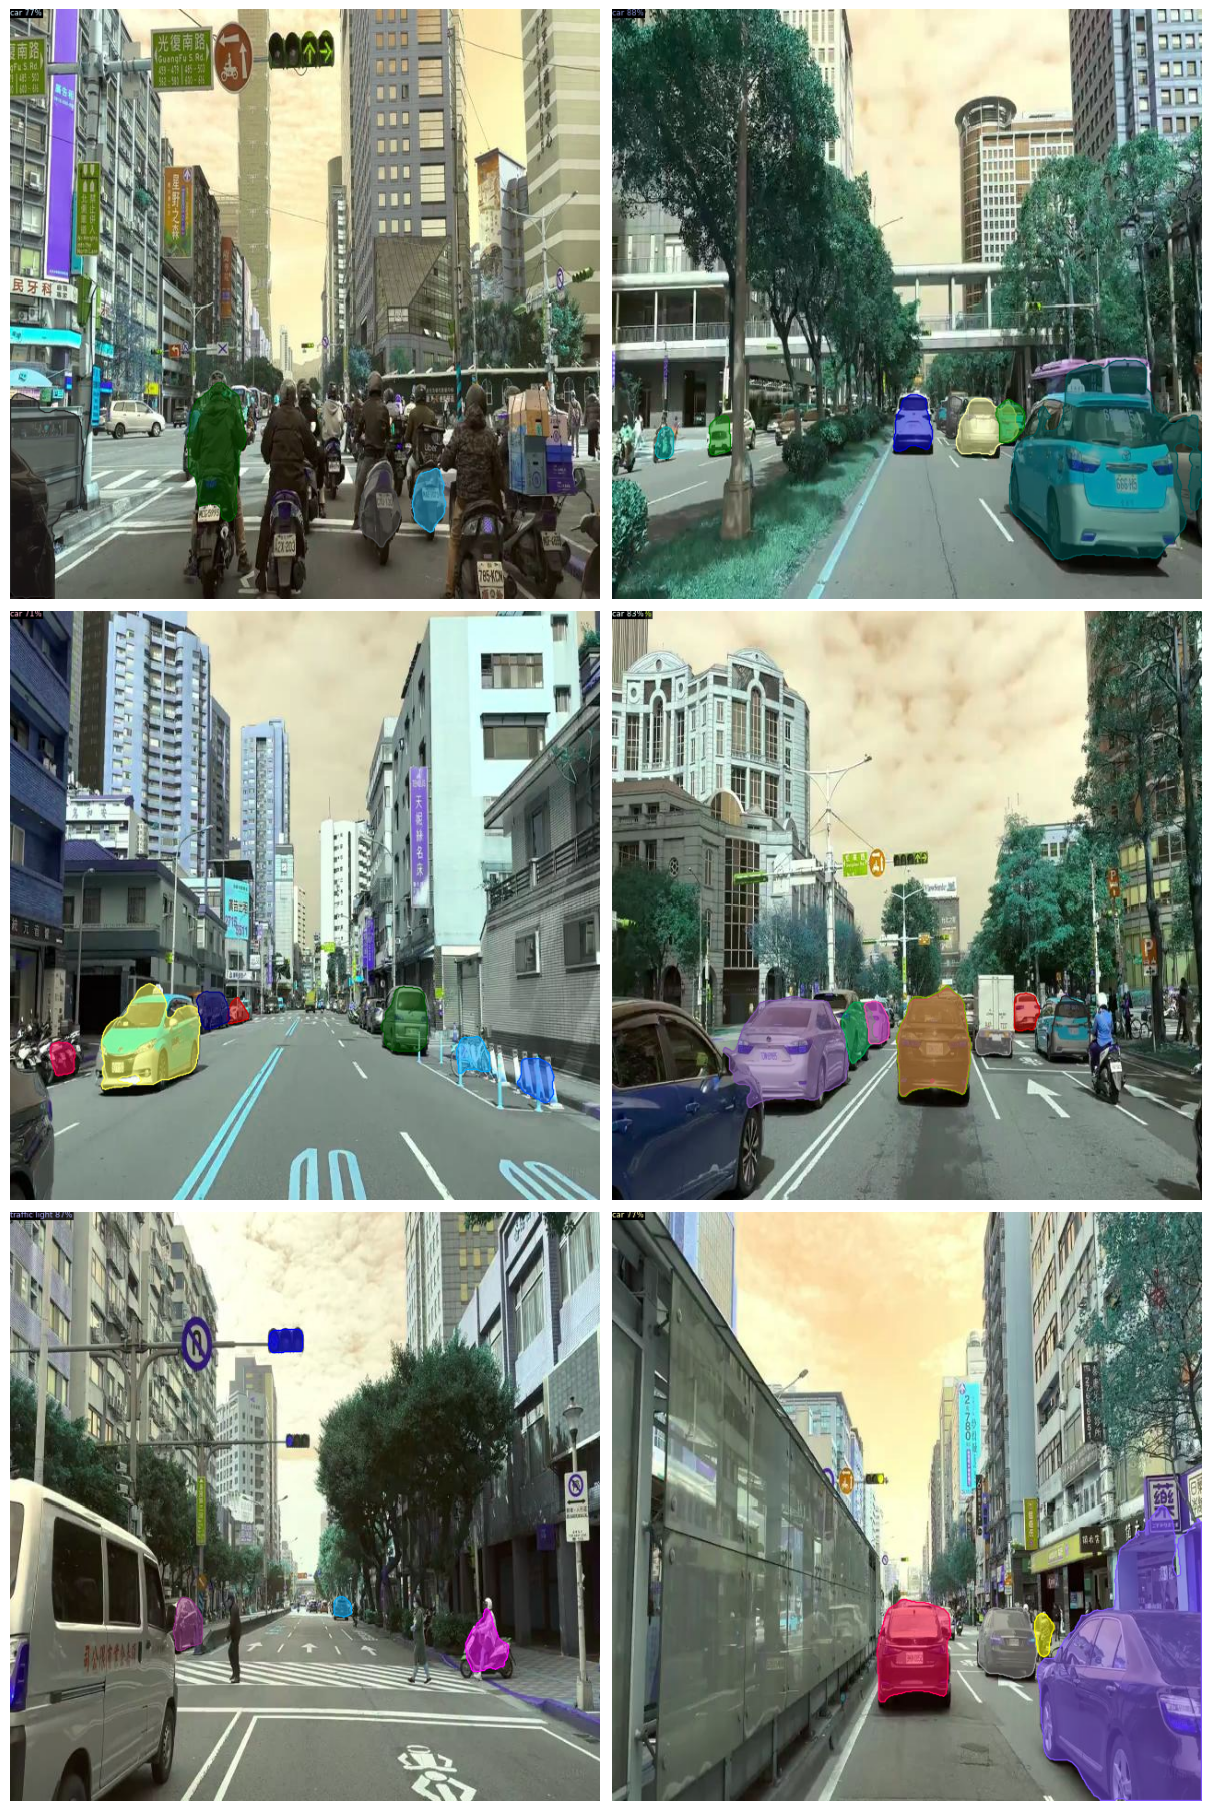

In [19]:
import random
import math
from detectron2.utils.visualizer import ColorMode
TRESH_TEST = 0.7
dataset_dicts = DatasetCatalog.get("instance_test")
num_samples = 6 # número de amostra para visualizar
figure, ax = plt.subplots(nrows=math.ceil(num_samples/2), ncols=2, figsize=(12,18), constrained_layout=True)
start_row = 0
start_col = 0
with torch.no_grad():
  predictor = DefaultPredictor(cfg_test)
  for d in random.sample(dataset_dicts, num_samples):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("instance_test"), scale=1, instance_mode=ColorMode.SEGMENTATION)
    instances_result  = v.draw_instance_predictions(outputs['instances'][[outputs['instances'].scores > TRESH_TEST][0].tolist()].to("cpu")).get_image()[:, :, ::-1]
    ax[start_row, start_col].imshow(instances_result)
    ax[start_row, start_col].set_axis_off()
    ax[start_row, start_col].set_xticklabels([])
    ax[start_row, start_col].set_yticklabels([])
    start_col = start_col + 1
    if start_col == 2:
        start_row = start_row + 1
        start_col = 0
    figure.subplots_adjust(wspace=0, hspace=0)
    #plt.imshow(instances_result)
plt.show()


# 8 Visualização gráfica das métricas e parâmetros de treino (loss, learning rate, etc...)

In [20]:
import os
import json
metric_file = os.path.join(OUTDIR, "metrics.json")

metrics = []
with open(metric_file, 'r') as infile:
  for line in infile.readlines():
    metrics.append(json.loads(line))

APmetrics = metrics[-1] if "segm/AP" in metrics[-1].keys() else None
if APmetrics is not None:
  metrics.pop(-1)
  APmetrics.pop('iteration', None) # não precisamos de iteration nos AP finais
  keys_to_del = []
  for key in APmetrics.keys():
      if "bbox" in key:
          keys_to_del.append(key)
  for k in keys_to_del:
      APmetrics.pop(k, None)

mt = dict()
for k in metrics[0].keys():
  _temp = [metrics[i][k] for i in range(len(metrics))]
  mt.update({k: _temp})

## Escolher as chaves de métricas válidas pra usar no plot

In [21]:
print("Keys válidas:", mt.keys())

Keys válidas: dict_keys(['data_time', 'eta_seconds', 'iteration', 'loss_ce', 'loss_ce_0', 'loss_ce_1', 'loss_ce_2', 'loss_ce_3', 'loss_ce_4', 'loss_ce_5', 'loss_ce_6', 'loss_ce_7', 'loss_ce_8', 'loss_dice', 'loss_dice_0', 'loss_dice_1', 'loss_dice_2', 'loss_dice_3', 'loss_dice_4', 'loss_dice_5', 'loss_dice_6', 'loss_dice_7', 'loss_dice_8', 'loss_mask', 'loss_mask_0', 'loss_mask_1', 'loss_mask_2', 'loss_mask_3', 'loss_mask_4', 'loss_mask_5', 'loss_mask_6', 'loss_mask_7', 'loss_mask_8', 'lr', 'rank_data_time', 'time', 'total_loss', 'validation_loss_ce', 'validation_loss_ce_0', 'validation_loss_ce_1', 'validation_loss_ce_2', 'validation_loss_ce_3', 'validation_loss_ce_4', 'validation_loss_ce_5', 'validation_loss_ce_6', 'validation_loss_ce_7', 'validation_loss_ce_8', 'validation_loss_dice', 'validation_loss_dice_0', 'validation_loss_dice_1', 'validation_loss_dice_2', 'validation_loss_dice_3', 'validation_loss_dice_4', 'validation_loss_dice_5', 'validation_loss_dice_6', 'validation_loss_dic

In [22]:
# insira as keys válidas (acima) aqui neste array conforme necessário menos as que começam com "validation_", as de validação o append é feito no plot para plot duplo
keys = ["total_loss", "lr", "loss_mask"] 

## Plotagem dos gráficos das métricas de treino e validação (plot duplo)

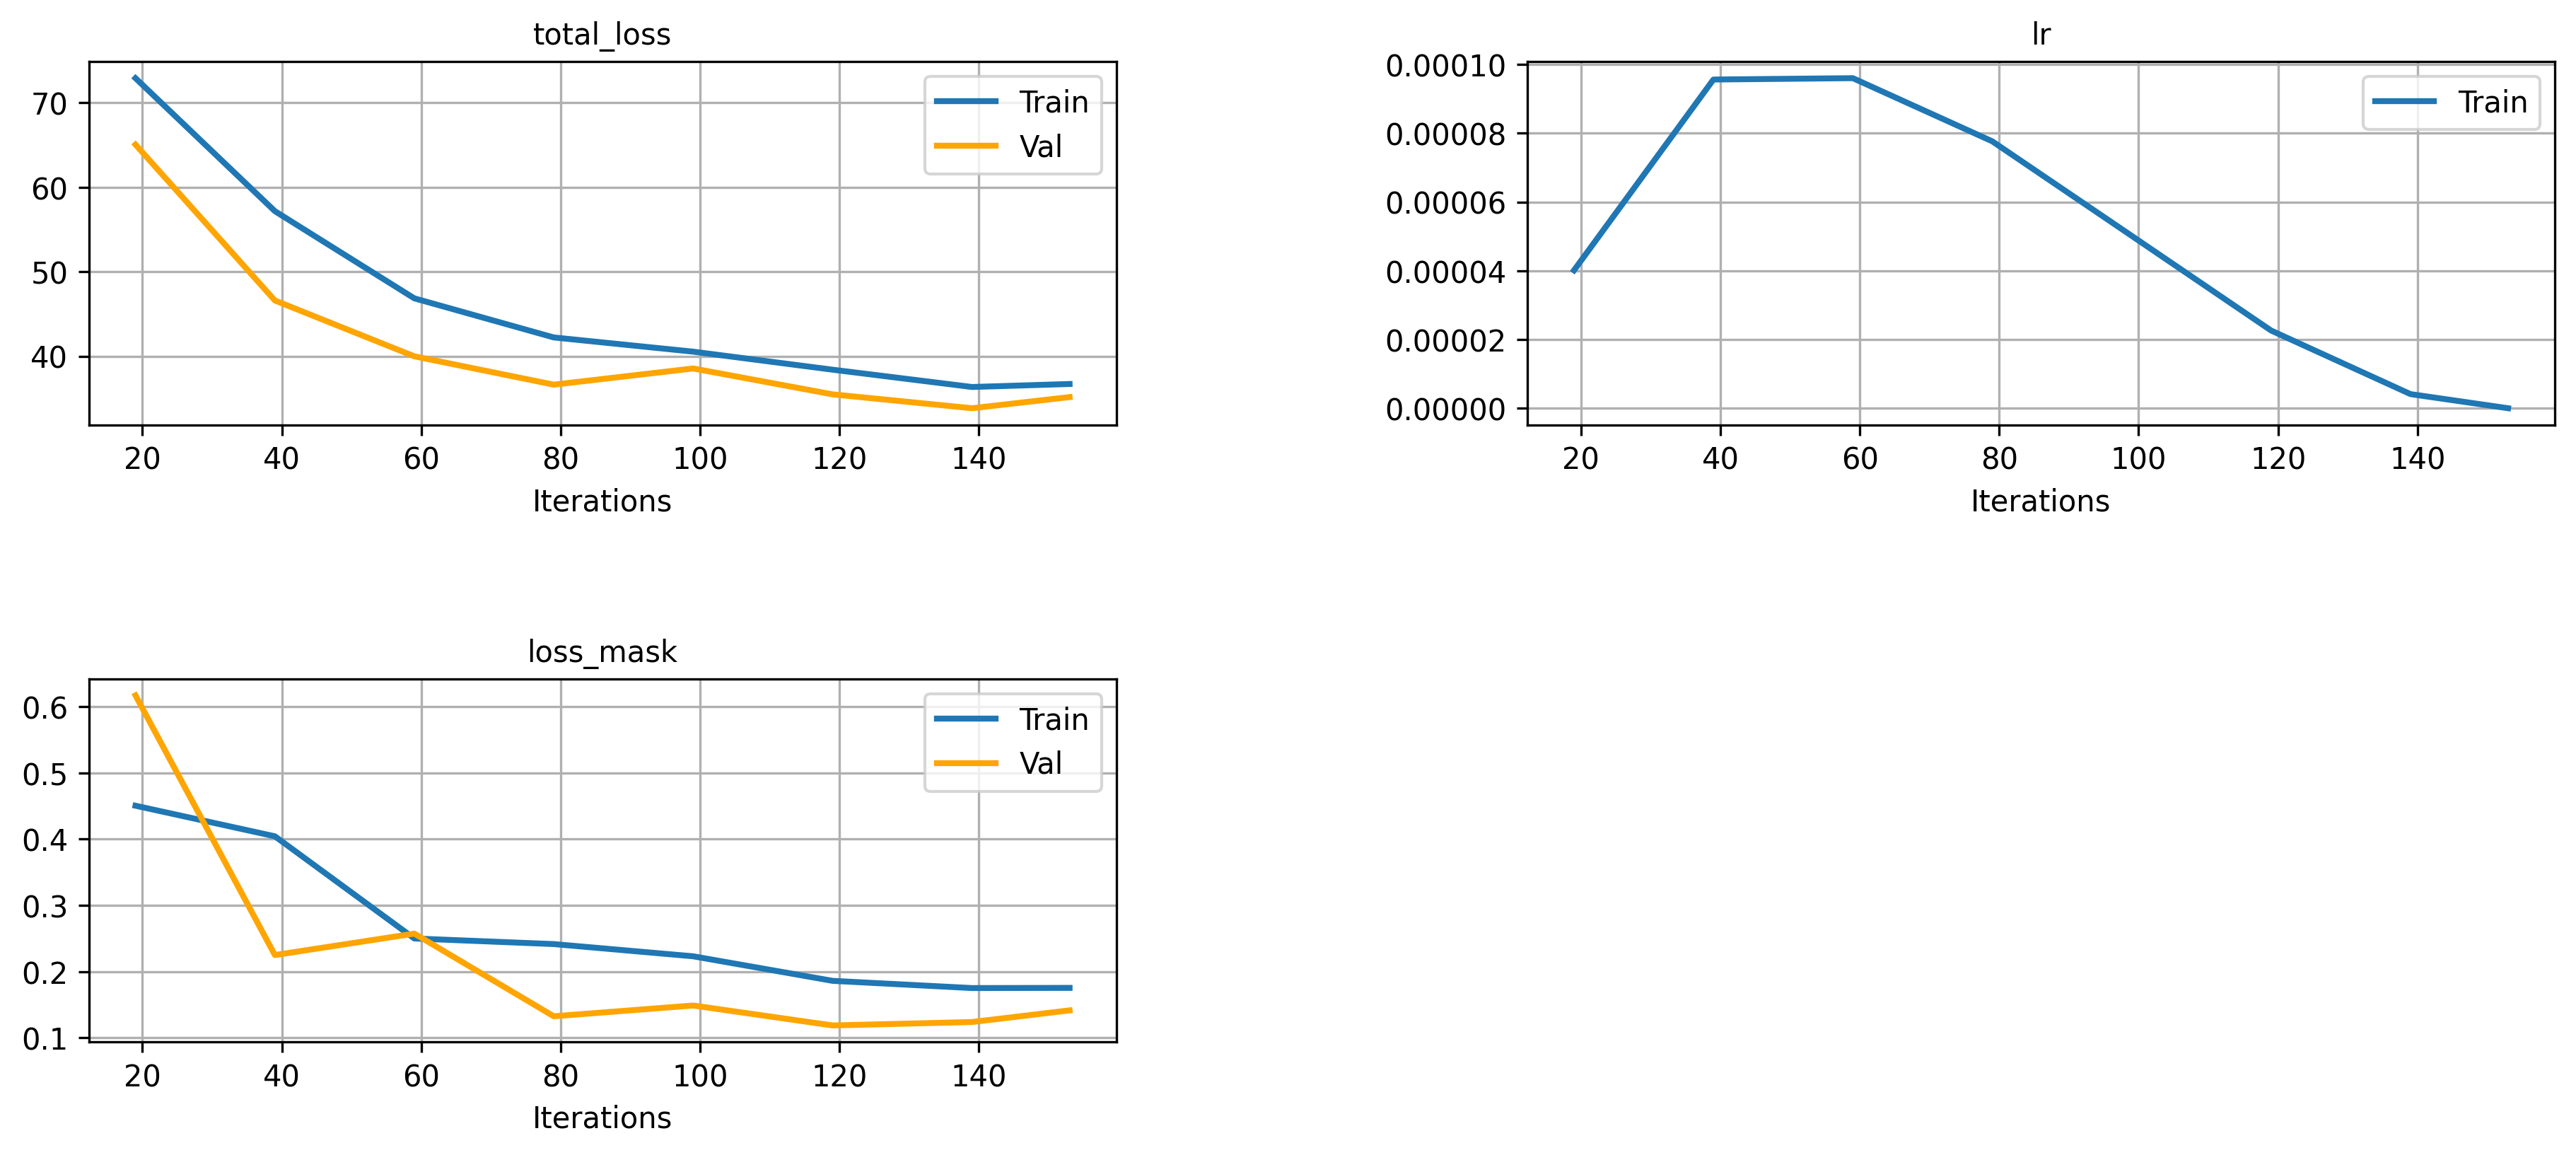

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,6), dpi=300)
fig.subplots_adjust(hspace=0.7, wspace=0.4)
row_index = 2
line_index = (len(keys)//row_index)+1 if len(keys)%row_index != 0 else len(keys)//row_index
plotcount = 1
for k in keys:
    _ax = fig.add_subplot(line_index, row_index, plotcount)
    _ax.set_yscale('linear')
    _ax.plot(mt["iteration"], mt[k], linewidth=2.0)
    if k != "lr":
        _ax.plot(mt["iteration"], mt["validation_"+k], linewidth=2.0, c='orange')
        plt.legend(["Train", "Val"], loc="upper right")
    else:
        plt.legend(["Train"], loc="upper right")
    _ax.set_xlabel('Iterations', fontsize=10)
    _ax.set_title(k, fontsize=10)
    plt.grid()
    plotcount +=1
plt.show()

## Visualizar as Métricas AP como uma tabela Pandas

In [24]:
#-- Visualizar inferência AP como tabela --
from IPython.display import display
import pandas as pd
if APmetrics is not None:
  df = pd.DataFrame.from_dict(APmetrics, orient='index') # key como linhas
  #df = pd.DataFrame(APmetrics, index=[0,]) # key como colunas
  display(df)

0
segm/AP                 8.635077
segm/AP-bus             1.603017
segm/AP-car            20.739931
segm/AP-motorcycle      7.896916
segm/AP-person          3.237309
segm/AP-traffic light   2.930302
segm/AP-truck          15.402986
segm/AP50              21.823944
segm/AP75               5.839251
segm/APl               25.541789
segm/APm               12.853607
segm/APs                8.370899

# 9 Realizar o Resumo de um treino interrompido ou abortado.

## Escolhendo o último peso salvo

In [25]:
from glob import glob
import time
import datetime
import pytz
if RESUMIR:
  pasta_para_resumir = PASTA_RESUMO
  if pasta_para_resumir == "":
    all_runs = glob(os.path.join(RUNS_PATH,"*/"))
    lrt = len(RUNS_PATH)
    last_date = None
    last_run = None
    last_time = None
    for _run in all_runs:
      _date, _time = _run[lrt:-1].split('2022')
      run_date = time.strptime(_date + '2022', "%d-%m-%Y")
      run_hour, run_min, run_sec = _time.strip('_').split('_')
      run_time = run_hour*60 + run_min*60 + run_sec
      if last_date is None:
        last_date = run_date
        last_run = _run
        last_time = run_time
      elif run_date > last_date:
        lastaadptação_date = run_date
        last_run = _run
        last_time = run_time
      elif run_date == last_date:
        if run_time > last_time:
          last_date = run_date
          last_run = _run
          last_time = run_time
      else:
        pass
    pasta_para_resumir = last_run
  else:
    pasta_para_resumir = os.path.join(RUNS_PATH, PASTA_RESUMO)

  print("Resumindo do diretorio:", pasta_para_resumir)
  models = glob(os.path.join(pasta_para_resumir, "*.pth"))
  selected_model = None
  aux = 0
  for m in models:
    numbers = ''.join([x for x in m if x.isdigit()])
    if int(numbers) > aux:
      selected_model = m
      aux = int(numbers)
  print("Resumindo do modelo:", selected_model)
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  
  _msg = "Iniciando configurações de resumo: OK"
  print(_msg)

## Carregamento das configurações para resumo e reinicio do treino.

In [26]:
import detectron2
from detectron2.utils.logger import setup_logger
import matplotlib.pyplot as plt
import datetime
import pytz
import numpy as np
import cv2
import os
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo

if RESUMIR:
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))
  _msg = "Iniciando resumo de treino: OK (resumo iniciado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
  print(_msg)

  

  RUNS_PATH = pasta_para_resumir # definindo run path de resumo
  cfg = get_cfg()
  add_deeplab_config(cfg_test)
  add_maskformer2_config(cfg_test)
  cfg.ONECYCLE = CfgNode({"LIMIT": 0.01, "MAX_MOMENTUM": 0.95, "MIN_MOMENTUM": 0.85, "THREE_PHASE": False})
  cfg.merge_from_file(os.path.join(RUNS_PATH, "mask2former_instance.yml"))
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
  cfg.MODEL.WEIGHTS = selected_model
  DatasetCatalog.clear()
  MetadataCatalog.clear()
  register_coco_instances("instance_train", {}, os.path.join(BASE_PATH, "dataset/simple_street_segmentation/train/train.json"), os.path.join(BASE_PATH, "dataset/simple_street_segmentation/train"))
  register_coco_instances("instance_val", {}, os.path.join(BASE_PATH, "dataset/simple_street_segmentation/valid/valid.json"), os.path.join(BASE_PATH, "dataset/simple_street_segmentation/valid"))
  print("Executando: " + str(cfg.SOLVER.MAX_ITER) + " iterations.")
  
  default_setup(cfg, '')
  # setup_logger(output=cfg.OUTPUT_DIR, distributed_rank=comm.get_rank(), name="mask2former")

  trainer = DeepUFSCTrainer(cfg)
  trainer.register_hooks([ValidationLoss(cfg)])
  pw_hook = [hook for hook in trainer._hooks if isinstance(hook, PeriodicWriter)]
  all_hooks = [hook for hook in trainer._hooks if not isinstance(hook, PeriodicWriter)]
  trainer._hooks = all_hooks + pw_hook

  if WANDB_LOGGER or NPT_LOGGER:
    exlogger_hook = ExternalLogger(npt=NPT_LOGGER, wndb=WANDB_LOGGER, resume=True)
    trainer.register_hooks([exlogger_hook])
  trainer.resume_or_load(resume=True) # True para resumir do checkpoint encontrado ou do melhor peso encontrado.
  trainer.train()
  time_now = datetime.datetime.now(pytz.timezone("America/Sao_Paulo"))

  
  _msg = "Resumo de treino finalizado em {dia}/{mes}/{ano} as {hora}:{minuto}:{segundo})".format(dia=time_now.day, mes=time_now.month, ano=time_now.year, hora=time_now.hour, minuto=time_now.minute, segundo=time_now.second)
  print(_msg)

<img src="http://lapix.ufsc.br/wp-content/uploads/2022/10/rodape-lapix.png">

